# U-Net Segmentation
The first step is to download the data by executing the commands below in the terminal or extract it in another way.

```bash
wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
mkdir lesson_8_data
mkdir lesson_8_data_output
mv images.tar.gz lesson_8_data
mv annotations.tar.gz lesson_8_data
cd lesson_8_data
tar -xf images.tar.gz
tar -xf annotations.tar.gz
```

In [2]:
images_path = "lesson_8_data/images"
annotations_path = "lesson_8_data/annotations/trimaps"

The data represents images of animals, along with segmentation masks indicating the object's location in the image with pixel-level accuracy. The images should be loaded as two separate sorted lists: one containing images and the other containing masks. It is important to ensure that the i-th image in the first list corresponds to the i-th mask in the second list. Additionally, due to the quantity and size of the images, they may not fit into memory. Therefore, a good idea would be to store their paths and load them during training.

In [3]:
# TODO Set the necessary paths
# Choose parameters depending on hardware capabilities
# Check if the data has been downloaded correctly.
 
import os
import cv2

img_name = "staffordshire_bull_terrier_31"
input_extension = ".jpg"
target_extension = ".png"
input_dir = "lesson_8_data/images"
target_dir = "lesson_8_data/annotations/trimaps"
# folder + file path (staffordshire_bull_terrier_31.jpg)
input_img_path = os.path.join(input_dir, img_name + input_extension)
target_img_path = os.path.join(target_dir, img_name + target_extension)
# input_img_paths - size of the image
img_size =  cv2.imread(input_img_path).shape[:2]
num_classes = 3 # Object, background, uncertain area between
batch_size = 128

In [4]:
# Ensure each dimension is a multiple of 2
new_height = int(img_size[0] / 2) * 2
new_width = int(img_size[1] / 2) * 2

# Update image size
img_size = (new_height, new_width)

You can plot a sample image and mask using the imshow function from the pyplot module of the matplotlib library:

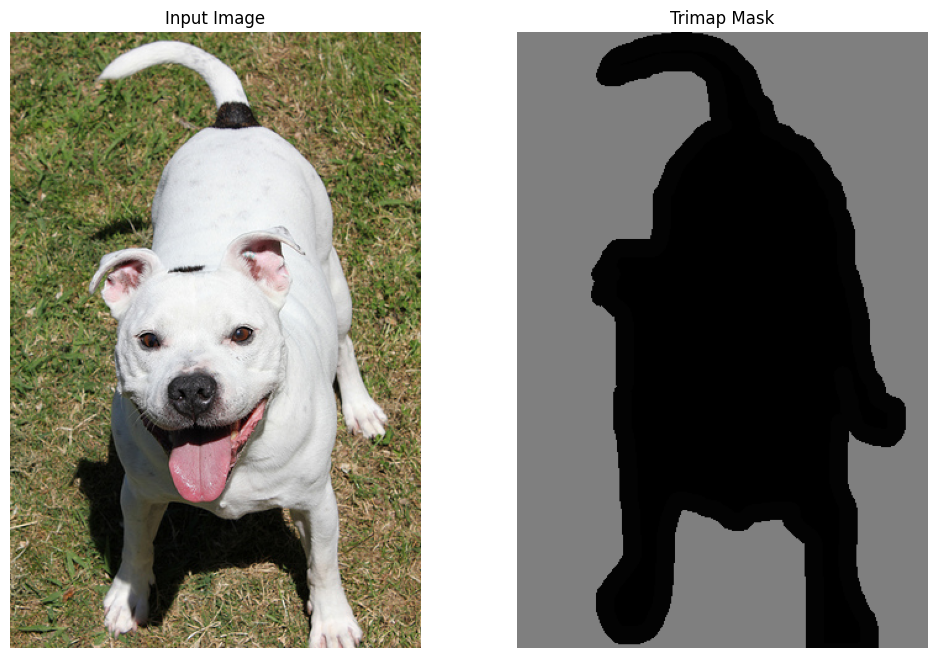

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

# TODO show an example image and the corresponding mask (target) image
# Load the image and trimap mask
img = PIL.Image.open(input_img_path)
trimap_mask = cv2.imread(target_img_path)

# Map the trimap mask to the corresponding colors (0, 127, 255) -> (1, 2, 3)
dict_colors = {1:0, 2:127, 3:255}
for i in range(1, num_classes):
    trimap_mask[np.where((trimap_mask == i).all(axis=2))] = dict_colors[i]

# Plot the image and trimap mask
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(trimap_mask)
plt.title('Trimap Mask')
plt.axis('off')

plt.show()

To be able to load images during training, it is necessary to implement an appropriate generator. None of the available generators loads images and their masks. Therefore, it is necessary to write your own generator. Such a class must inherit from the keras.utils.Sequence class and implement the methods: len(self) and getitem(self, idx).

Alternatively, you can use existing tools and use two separate generators - one that loads images and another that loads masks, and then combine them into one.

In [6]:
# For our custom function to function as a generator and be usable, for example, by fit, 
# it must have three definitions: __init__, __len__, and __getitem__.
import keras
 
class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
    
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """ Returns tuple (input, target) correspond to batch #idx. """
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # Load images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = PIL.Image.open(path)
            img = img.resize(self.img_size[::-1])  # Reverse the order of dimensions
            img_array = np.array(img)  # Convert the image to an array
            x[j] = img_array

        # Load masks
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = PIL.Image.open(path)
            img = img.resize(self.img_size[::-1])  # Reverse the order of dimensions
            img_array = np.array(img)  # Convert the image to an array
            img_array = np.expand_dims(img_array, axis=2)
            y[j] = img_array
            
        return x, y

2023-12-25 18:05:20.290663: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 18:05:20.290694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 18:05:20.290720: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 18:05:20.297065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-25 18:05:21.112087: W tensorflow/compiler/

EN: The getitem method is called for each batch once during one epoch by passing an index. The method should return a tuple with two elements, where the first element is a set of images with the size (batch size, height, width, number of channels), and the second element represents the set of masks for the loaded images. This prepared object of the class is passed to the fit method, which implements the training process. However, it is necessary to implement the architecture of the network beforehand. According to the lecture content, it has a U-shaped structure, and the operations within it include convolutions, max pooling operations, and transposed convolutions. The input to the network is an image, while the output is a mask. It is good to start with the definition of helper functions. 

A convolutional block:

In [7]:
#  The input to the network is an image, while the output is a mask. Padding is used to ensure that the input and output are the same size.
from tensorflow.keras import layers
def double_conv_block(x, n_filters):
    """ Double Convolutional Block """
    x = layers.Conv2D(n_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(n_filters, (3, 3), padding='same', activation='relu')(x)
    return x


EN: Sampling block:

In [8]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D((2, 2), padding='same')(f)
    p = layers.Dropout(0.5)(p)
    return f, p

EN: Upsampling block:

In [9]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    print("X after Conv2DTranspose:", x.shape)
    print("Conv Features Shape:", conv_features.shape)
    
    # Manually align sizes in any dimension
    diff_x = x.shape[1] - conv_features.shape[1]
    diff_y = x.shape[2] - conv_features.shape[2]
    
    # Align conv_features
    if diff_x > 0:
        conv_features = layers.ZeroPadding2D(((0, diff_x), (0, 0)))(conv_features)
    else:
        x = layers.ZeroPadding2D(((0, -diff_x), (0, 0)))(x)
    
    if diff_y > 0:
        conv_features = layers.ZeroPadding2D(((0, 0), (0, diff_y)))(conv_features)
    else:
        x = layers.ZeroPadding2D(((0, 0), (0, -diff_y)))(x)

    print("X after padding:", x.shape)
    print("Conv Features Shape after padding:", conv_features.shape)

    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.5)(x)
    x = double_conv_block(x, n_filters)
    return x


EN: Given all these operations, we can implement the network:

In [10]:
import tensorflow as tf
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    print("f1, p1 shapes: ", f1.shape, p1.shape)
    print("f2, p2 shapes: ", f2.shape, p2.shape)
    print("f3, p3 shapes: ", f3.shape, p3.shape)
    print("f4, p4 shapes: ", f4.shape, p4.shape)
    print("bottleneck shape: ", bottleneck.shape)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
keras.backend.clear_session()
model = get_model(img_size, num_classes)

f1, p1 shapes:  (None, 500, 332, 64) (None, 250, 166, 64)
f2, p2 shapes:  (None, 250, 166, 128) (None, 125, 83, 128)
f3, p3 shapes:  (None, 125, 83, 256) (None, 63, 42, 256)
f4, p4 shapes:  (None, 63, 42, 512) (None, 32, 21, 512)
bottleneck shape:  (None, 32, 21, 1024)
X after Conv2DTranspose: (None, 64, 42, 512)
Conv Features Shape: (None, 63, 42, 512)
X after padding: (None, 64, 42, 512)
Conv Features Shape after padding: (None, 64, 42, 512)
X after Conv2DTranspose: (None, 128, 84, 256)
Conv Features Shape: (None, 125, 83, 256)
X after padding: (None, 128, 84, 256)
Conv Features Shape after padding: (None, 128, 84, 256)
X after Conv2DTranspose: (None, 256, 168, 128)
Conv Features Shape: (None, 250, 166, 128)
X after padding: (None, 256, 168, 128)
Conv Features Shape after padding: (None, 256, 168, 128)
X after Conv2DTranspose: (None, 512, 336, 64)
Conv Features Shape: (None, 500, 332, 64)
X after padding: (None, 512, 336, 64)
Conv Features Shape after padding: (None, 512, 336, 64)


EN: To verify the network architecture, you can print it to the screen using model.summary().

In [11]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 332, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 500, 332, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 500, 332, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 250, 166, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

A good practice is to split the dataset into training, validation, and test subsets. It is necessary to divide the dataset into appropriate subsets. For simplicity, two sets are sufficient – training and validation.

In [12]:
# TODO: Divide the data into training set and validation set (based on paths)
from sklearn.model_selection import train_test_split
input_img_paths = sorted(
    [
        os.path.join(images_path, fname)
        for fname in os.listdir(images_path)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(annotations_path, fname)
        for fname in os.listdir(annotations_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of samples:", len(input_img_paths))
print("Number of masks:", len(target_img_paths))


Number of samples: 7390
Number of masks: 7390


In [13]:
# Split our img paths into a training and a validation set
train_input_img_paths, val_input_img_paths, train_target_img_paths, val_target_img_paths = train_test_split(input_img_paths, target_img_paths, test_size=0.2, random_state=42)
print("Number of training samples:", len(train_input_img_paths))
print("Number of validation samples:", len(val_input_img_paths))

Number of training samples: 5912
Number of validation samples: 1478


In [14]:
# TODO: Create two generators for training and validation
train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

EN: Before starting the training itself, it is necessary to define the loss function and compile the model. Additionally, it is advisable to set up a callback to save the best model. Finally, the fit function is called with the appropriate arguments.

In [15]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[model_checkpoint_callback])

Epoch 1/10


2023-12-25 18:05:41.485517: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5439488000 exceeds 10% of free system memory.


: 